In [1]:
import os
import numpy as np
import math as m
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda, int32, int64, float32, jit
import matplotlib.pyplot as plt

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
@vectorize([float32(float32)], fastmath=True) 
def f_exp (V):
    return np.exp(V)

@vectorize([float32(float32)], fastmath=True) 
def f_log (V):
    return np.log(V)

In [3]:
A = np.array([2, 5, 10, 3, 8]).astype(np.float32)

print(f_exp(A))
print(f_log(A))

[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]
[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [4]:
@vectorize([float32(float32,float32,float32)], fastmath=True) 
def f_gaus (x, mean, stdev):
    return ( 1./(np.sqrt(2.*np.pi*stdev**2)) )*np.exp( -((x-mean)**2)/(2.*stdev**2) )

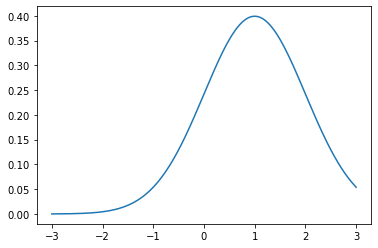

In [5]:
V = []
X = []

mean = np.array(1.).astype(np.float32)
stdev = np.array(1.).astype(np.float32)

for i in range(0,100000):
    x = np.array( -3 + 6.*i/100000. ).astype(np.float32)
    V.append( f_gaus ( x, mean, stdev ) )
    X.append(x)

plt.plot(X,V)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

In [6]:
@jit("float32[:](int16[:],float32)",nopython=True)
def suppression_f (data, threshold):
    Data = [] 
    size = len(data)
    for d in data:
        if(d>threshold): Data.append(d)
        else: Data.append(0)   
    return np.array(Data).astype(float32)

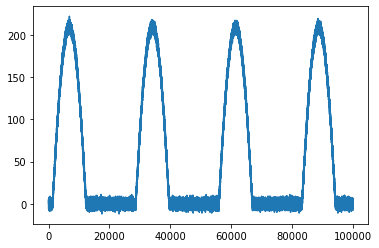

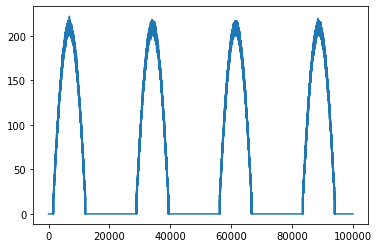

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

threshold = 15.
x = np.linspace(0,100000,100000)
plt.plot(x,data)
plt.show()

f = suppression_f(data, 15)
plt.plot(x,f)
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [3]:
@cuda.jit
def k(x, y, result):
    alpha = 1
    c = 0
    x, y = cuda.grid(2)
    result[x,y] = np.tanh( alpha*np.dot(np.transpose(X[x,y]),Y[x,y])+c )

    
X = np.random.rand(3,3)
Y = np.random.rand(3,3)



threadsperblock = (3, 3)
blockspergrid_x = int(m.ceil(X.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(Y.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

result = np.zeros((3,3))

k[blockspergrid, threadsperblock](X,Y,result)

print(result)

[[0.29255995 0.21517366 0.2301378 ]
 [0.1944261  0.00735454 0.59917177]
 [0.02263058 0.0841745  0.18361242]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [14]:
from __future__ import division
@cuda.jit
def cos_kernel(io_array,result):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        result[x,y,z] = np.cos(io_array[x,y,z])

In [15]:
#Sorry but I was not able to use a 256x256x256 matrix in this exercise, I don't know if I made 
#a mistake or I just missed something 

data = np.random.rand(25,25,25)*2*m.pi 

threadsperblock = (8, 8, 4)
blockspergrid_x = int(m.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(m.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

result = np.zeros((25,25,25))

cos_kernel[blockspergrid, threadsperblock](data, result)

print(result)

[[[ 3.86350626e-01 -7.27241492e-01  9.86014719e-01 ... -8.75878693e-01
    8.81543988e-01 -9.02278153e-01]
  [ 7.84935347e-01  9.83461636e-02 -1.08951203e-01 ... -8.03810776e-02
   -7.81443185e-01 -6.33613600e-01]
  [ 9.86668141e-01  8.44833661e-01  7.11627715e-01 ...  3.41419177e-01
    8.61077864e-01  7.42667102e-01]
  ...
  [ 9.79226516e-01 -9.78614033e-01  1.66150119e-01 ...  8.25466552e-01
    9.98460669e-01 -6.14663369e-01]
  [ 6.82290148e-01  5.90970309e-01  4.56877506e-01 ... -9.99999648e-01
    5.14188863e-01 -9.99712901e-01]
  [ 4.80082538e-01 -5.76403069e-01 -1.21928863e-01 ...  9.42053455e-01
    8.20704878e-01  7.69088582e-01]]

 [[ 6.16754776e-01 -2.27914684e-01 -9.22267023e-01 ...  8.93072863e-01
    1.35613466e-01 -3.40203004e-02]
  [-4.45610729e-01  9.18393187e-01  9.22362199e-01 ...  9.50875975e-01
    9.94066021e-01 -3.14533777e-01]
  [ 3.00303618e-01 -1.89182226e-01  9.18751558e-01 ... -9.91017126e-01
   -5.30030400e-01  5.66972543e-02]
  ...
  [ 9.99993901e-01 -7.0

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [22]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.rand(24,12)
B = np.random.rand(12,22)
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (8,8)
blockspergrid_x = int(m.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid =  (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A,B,C)
print(C)

[[2.5917715  3.39001447 1.83193647 3.07028869 3.02319097 2.9742752
  3.3342431  3.44120055 3.29207819 3.15511406 3.52293457 2.16830544
  3.36750705 2.99022098 4.17847876 3.87426972 3.43801169 3.26044173
  3.43813205 3.96833691 3.68898734 3.71878691]
 [2.66055472 3.28962663 1.8764615  2.67551873 2.71120443 2.92246708
  3.17726012 3.13051733 2.58585035 3.36769163 3.68078383 2.08172247
  3.11625251 3.15270306 4.05257797 3.81716079 3.33129    3.12865338
  3.58757491 4.05089296 3.61971189 3.93519864]
 [2.39148157 2.82999856 1.93668336 2.7756165  2.75897775 2.06605956
  3.24185372 2.40637291 2.89403852 2.71762464 3.84439615 1.91778284
  3.09609241 2.8485688  3.93562168 3.77075274 3.06955752 2.70229179
  2.77513076 3.13499145 3.44515142 3.47041618]
 [1.70739022 1.84240597 1.45530097 2.18830625 2.16963423 1.50845707
  2.51481005 1.8297391  2.51203381 1.47299449 2.65877824 1.01220603
  1.75707131 1.83527805 2.71824642 2.64717465 2.63557545 1.84668951
  1.90741784 1.7859283  2.20877507 2.6966783